In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, MissingIndicator
from sklearn.pipeline import Pipeline
import numpy as np
from scipy.stats import norm

# Load your data into a DataFrame
df = pd.read_csv('data/food_crises_updated.csv')



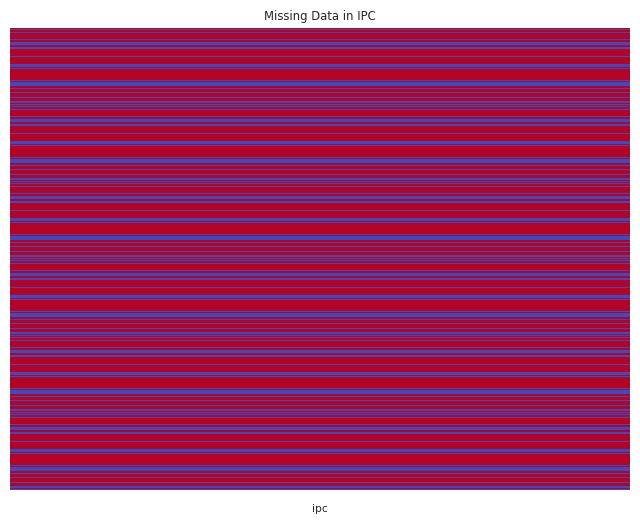

In [40]:


# Create a missing data heatmap for the column of interest using the 'coolwarm' colormap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['ipc']].isnull(), cmap='coolwarm', cbar=False, yticklabels=False)
plt.title('Missing Data in IPC')
plt.show()


In [41]:
# Calculate summary statistics for the column with missing data
summary_stats = df[['ipc']].describe()

# Compare statistics for missing and non-missing values
summary_stats_missing = df[df['ipc'].isnull()][['ipc']].describe()
summary_stats_not_missing = df[~df['ipc'].isnull()][['ipc']].describe()

print("Summary statistics for missing values:")
print(summary_stats_missing)

print("\nSummary statistics for non-missing values:")
print(summary_stats_not_missing)


Summary statistics for missing values:
       ipc
count  0.0
mean   NaN
std    NaN
min    NaN
25%    NaN
50%    NaN
75%    NaN
max    NaN

Summary statistics for non-missing values:
               ipc
count  3042.000000
mean      2.124918
std       0.896948
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000


In [42]:
summary_stats = df[['ipc']].describe()

summary_stats

,ipc
count,3042.000000
mean,2.124918
std,0.896948
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


In [43]:
# Calculate correlations with other columns
correlation_matrix = df.corr()

# Extract the correlation with the column of interest
correlation_with_column = correlation_matrix['ipc']

print("Correlation with other columns:")
print(correlation_with_column)


Correlation with other columns:
district_code      0.232751
centx              0.084513
centy              0.246221
year               0.612337
month              0.021450
ipc                1.000000
ha                 0.158948
ndvi_mean         -0.021316
ndvi_anom          0.208910
rain_mean          0.007412
rain_anom          0.086770
et_mean           -0.055851
et_anom            0.068227
count_violence     0.121199
sum_fatalities     0.042918
food_price_idx     0.553037
area              -0.014956
cropland_pct      -0.006450
pop                0.077619
ruggedness_mean   -0.151872
pasture_pct        0.321639
Name: ipc, dtype: float64


In [44]:
# CALCULATE THE CORRELATION FOR GREATER UPPER NILE
# Filter the DataFrame for the selected region
great_up = df[df['administrative_region'] == 'Greater Upper Nile']

# Calculate the correlation matrix for the selected data
correlation_matrix = great_up.corr()

correlation_matrix['ipc']

district_code     -0.073789
centx             -0.099228
centy             -0.131567
year               0.636702
month              0.036787
ipc                1.000000
ha                 0.014138
ndvi_mean          0.159314
ndvi_anom          0.283401
rain_mean          0.155415
rain_anom          0.145341
et_mean            0.099447
et_anom            0.082940
count_violence     0.100809
sum_fatalities     0.043597
food_price_idx     0.488236
area               0.020064
cropland_pct      -0.085547
pop                0.155297
ruggedness_mean   -0.050628
pasture_pct        0.153195
Name: ipc, dtype: float64

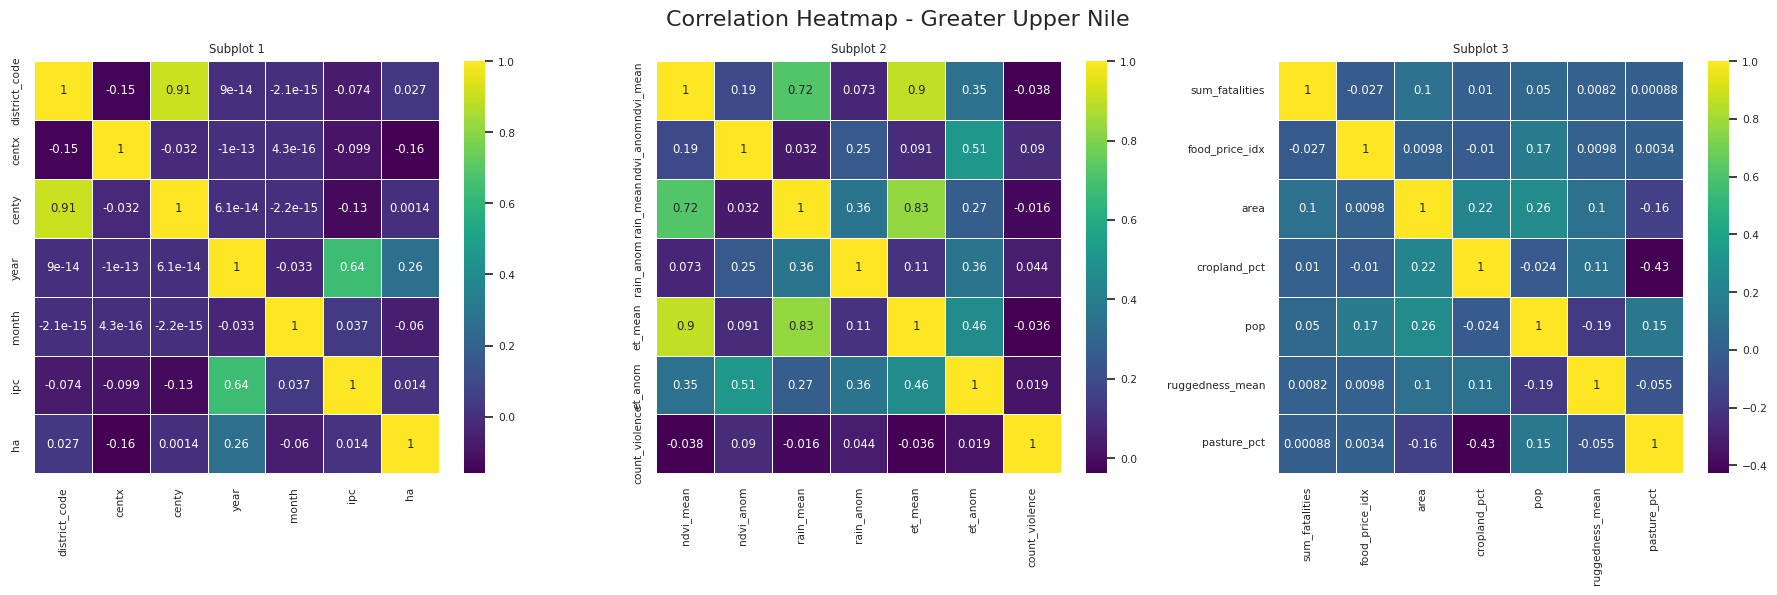

In [45]:
# PLOT THE CORRELATION MATRIX FOR GREATER UPPER NILE
# Split the columns into groups of 9
subset_columns = [correlation_matrix.columns[i:i + 7] for i in range(0, len(correlation_matrix.columns), 7)]

# Create subplots for each group of columns
num_subplots = len(subset_columns)

fig, axes = plt.subplots(1, num_subplots, figsize=(18, 6))

for i in range(num_subplots):
    sns.set(font_scale=0.7)  # Adjust font size if needed
    ax = axes[i]
    subset_corr_matrix = correlation_matrix.loc[subset_columns[i], subset_columns[i]]
    sns.heatmap(subset_corr_matrix, annot=True, cmap='viridis',
                xticklabels=True, yticklabels=True, linewidths=.5, ax=ax)
    ax.set_title(f'Subplot {i + 1}')

plt.suptitle('Correlation Heatmap - Greater Upper Nile', fontsize=16)
plt.tight_layout()
plt.show()

In [46]:
# CALCULATE THE CORRELATION FOR Bahr El Ghazal
# Filter the DataFrame for the selected region
bahr_el = df[df['administrative_region'] == 'Bahr El Ghazal']

# Calculate the correlation matrix for the selected data
correlation_matrix = bahr_el.corr()

correlation_matrix['ipc']

district_code      0.076627
centx             -0.075184
centy              0.169134
year               0.633606
month              0.036800
ipc                1.000000
ha                 0.180086
ndvi_mean          0.086325
ndvi_anom          0.124932
rain_mean          0.158888
rain_anom          0.129263
et_mean            0.078412
et_anom            0.114314
count_violence     0.091983
sum_fatalities    -0.047433
food_price_idx     0.602395
area              -0.067577
cropland_pct       0.146773
pop                0.234691
ruggedness_mean   -0.109764
pasture_pct        0.123272
Name: ipc, dtype: float64

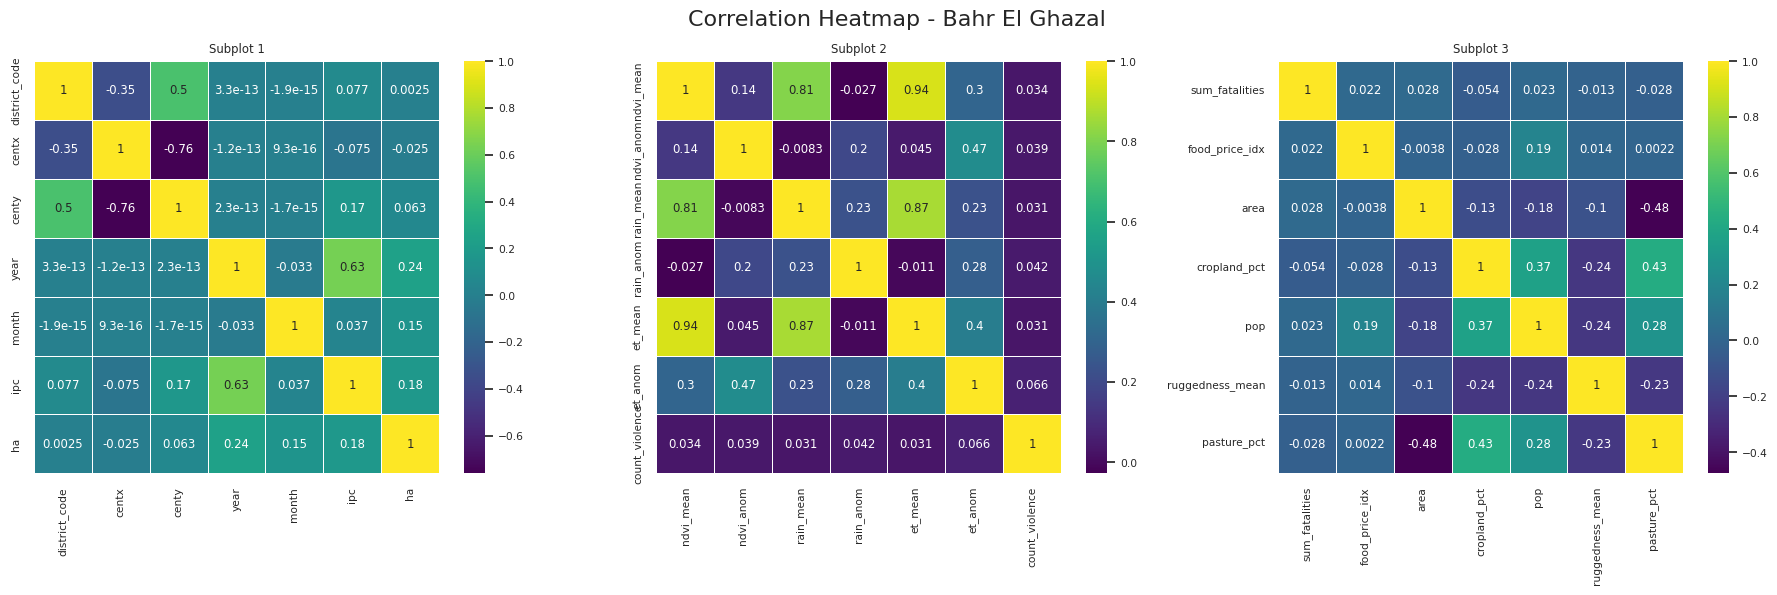

In [47]:
# PLOT THE CORRELATION MATRIX FOR Bahr El Ghazal
# Split the columns into groups of 9
subset_columns = [correlation_matrix.columns[i:i + 7] for i in range(0, len(correlation_matrix.columns), 7)]

# Create subplots for each group of columns
num_subplots = len(subset_columns)

fig, axes = plt.subplots(1, num_subplots, figsize=(18, 6))

for i in range(num_subplots):
    sns.set(font_scale=0.7)  # Adjust font size if needed
    ax = axes[i]
    subset_corr_matrix = correlation_matrix.loc[subset_columns[i], subset_columns[i]]
    sns.heatmap(subset_corr_matrix, annot=True, cmap='viridis',
                xticklabels=True, yticklabels=True, linewidths=.5, ax=ax)
    ax.set_title(f'Subplot {i + 1}')

plt.suptitle('Correlation Heatmap - Bahr El Ghazal', fontsize=16)
plt.tight_layout()
plt.show()

In [48]:
# CALCULATE THE CORRELATION FOR Equatoria
# Filter the DataFrame for the selected region
equatoria = df[df['administrative_region'] == 'Equatoria']

# Calculate the correlation matrix for the selected data
correlation_matrix = equatoria.corr()

correlation_matrix['ipc']

district_code      0.076613
centx              0.311179
centy             -0.041526
year               0.664034
month             -0.010740
ipc                1.000000
ha                 0.160484
ndvi_mean         -0.148691
ndvi_anom          0.122580
rain_mean         -0.110516
rain_anom          0.009112
et_mean           -0.105088
et_anom            0.038208
count_violence     0.186081
sum_fatalities     0.151902
food_price_idx     0.700130
area               0.073100
cropland_pct       0.213106
pop                0.164045
ruggedness_mean    0.051495
pasture_pct        0.266323
Name: ipc, dtype: float64

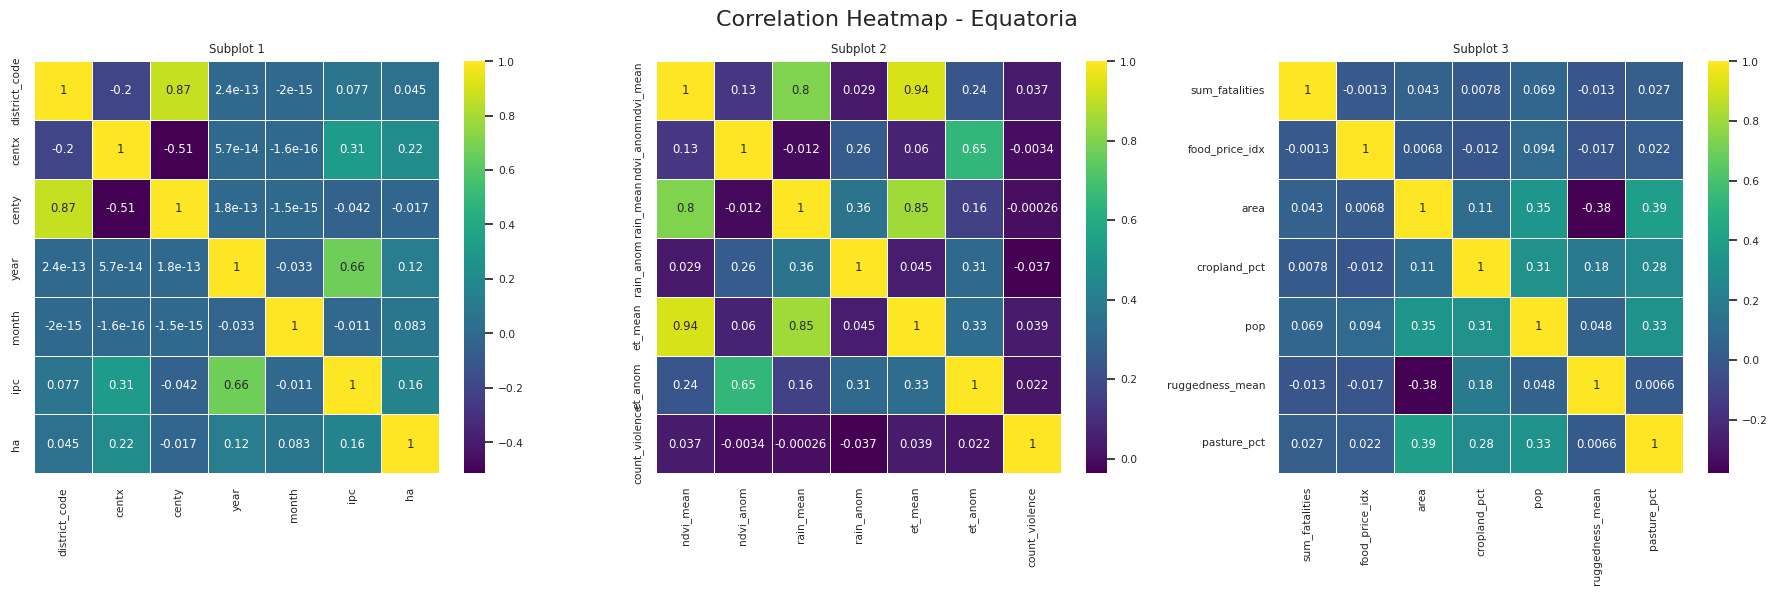

In [49]:
# PLOT THE CORRELATION MATRIX FOR Equatoria
# Split the columns into groups of 9
subset_columns = [correlation_matrix.columns[i:i + 7] for i in range(0, len(correlation_matrix.columns), 7)]

# Create subplots for each group of columns
num_subplots = len(subset_columns)

fig, axes = plt.subplots(1, num_subplots, figsize=(18, 6))

for i in range(num_subplots):
    sns.set(font_scale=0.7)  # Adjust font size if needed
    ax = axes[i]
    subset_corr_matrix = correlation_matrix.loc[subset_columns[i], subset_columns[i]]
    sns.heatmap(subset_corr_matrix, annot=True, cmap='viridis',
                xticklabels=True, yticklabels=True, linewidths=.5, ax=ax)
    ax.set_title(f'Subplot {i + 1}')

plt.suptitle('Correlation Heatmap - Equatoria', fontsize=16)
plt.tight_layout()
plt.show()

In [50]:


# Split 'year_month' into 'year' and 'month' columns
df['year'] = df['year_month'].str.split('_').str[0].astype(int)
df['month'] = df['year_month'].str.split('_').str[1].astype(int)

# Define a reference date (e.g., '2007-01-01' for the first day of the first month)
reference_date = datetime.datetime(2007, 1, 1)

# Calculate the number of months since the reference date
df['year_month_numeric'] = (df['year'] - reference_date.year) * 12 + (df['month'] - reference_date.month)


# Create a binary indicator variable for missingness in the column of interest
df['missing_indicator'] = df['ipc'].isnull().astype(int)

# Fit a logistic regression model to predict the missingness
model = sm.Logit(df['missing_indicator'], sm.add_constant(df[['year_month_numeric']]))  # Add other relevant variables
results = model.fit()

# Perform Little's MCAR test
mcar_test = results.prsquared
print("Little's MCAR Test p-value:", mcar_test)



Optimization terminated successfully.
         Current function value: 0.549511
         Iterations 5
Little's MCAR Test p-value: 0.016679300591537882


In [51]:
# Calculate the percentage of missing values for the column of interest
missing_percentage = (df['ipc'].isnull().sum() / len(df)) * 100
print(f"Percentage of missing values in ipc: {missing_percentage:.2f}%")


Percentage of missing values in ipc: 75.32%


In [52]:
df

,country,district_code,district,centx,centy,year_month,year,month,ipc,ha,...,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date,province,administrative_region,year_month_numeric,missing_indicator
0,South Sudan,74,Bor,32.00486,6.465644,2007_01,2007,1,NaN,NaN,...,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-01-01,Greater Upper Nile,Greater Upper Nile,0,1
1,South Sudan,74,Bor,32.00486,6.465644,2007_02,2007,2,NaN,NaN,...,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-02-01,Greater Upper Nile,Greater Upper Nile,1,1
2,South Sudan,74,Bor,32.00486,6.465644,2007_03,2007,3,NaN,NaN,...,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-03-01,Greater Upper Nile,Greater Upper Nile,2,1
3,South Sudan,74,Bor,32.00486,6.465644,2007_04,2007,4,NaN,NaN,...,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-04-01,Greater Upper Nile,Greater Upper Nile,3,1
4,South Sudan,74,Bor,32.00486,6.465644,2007_05,2007,5,NaN,NaN,...,14008.3300,7.961984,239344.0,11393.760,90.8503,2007-05-01,Greater Upper Nile,Greater Upper Nile,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12319,South Sudan,151,Malakal,31.64280,9.658457,2019_10,2019,10,3.0,0.0,...,757.7855,13.068690,102228.0,7145.909,85.5000,2019-10-01,Greater Upper Nile,Greater Upper Nile,153,0
12320,South Sudan,151,Malakal,31.64280,9.658457,2019_11,2019,11,NaN,NaN,...,757.7855,13.068690,102228.0,7145.909,85.5000,2019-11-01,Greater Upper Nile,Greater Upper Nile,154,1
12321,South Sudan,151,Malakal,31.64280,9.658457,2019_12,2019,12,NaN,NaN,...,757.7855,13.068690,102228.0,7145.909,85.5000,2019-12-01,Greater Upper Nile,Greater Upper Nile,155,1
12322,South Sudan,151,Malakal,31.64280,9.658457,2020_01,2020,1,NaN,NaN,...,757.7855,13.068690,163171.3,7145.909,85.5000,2020-01-01,Greater Upper Nile,Greater Upper Nile,156,1


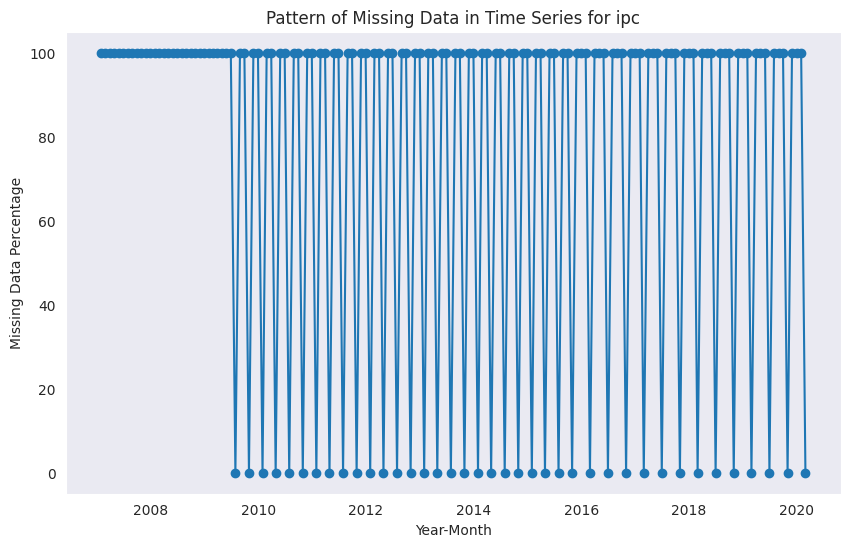

In [2]:

# Function to convert mixed date formats into a datetime column
def convert_to_datetime(value):
    try:
        return pd.to_datetime(value, format='%Y-%m-%d')
    except ValueError:
        parts = value.split('_')
        year = int(parts[0])
        month = int(parts[1])
        return pd.to_datetime(f'{year}-{month:02d}', format='%Y-%m')

# Apply the conversion function to the 'year_month' column
df['datetime'] = df['year_month'].apply(convert_to_datetime)

# Set the 'date' column as the index
df.set_index('datetime', inplace=True)

# Calculate the missing data percentage for each time point
missing_data_percentage = df['ipc'].isnull().astype(int).resample('M').mean() * 100

# Plot the missing data percentage over time (monthly)
plt.figure(figsize=(10, 6))
plt.plot(missing_data_percentage.index, missing_data_percentage.values, marker='o', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel('Missing Data Percentage')
plt.title('Pattern of Missing Data in Time Series for ipc')
plt.grid()
plt.show()

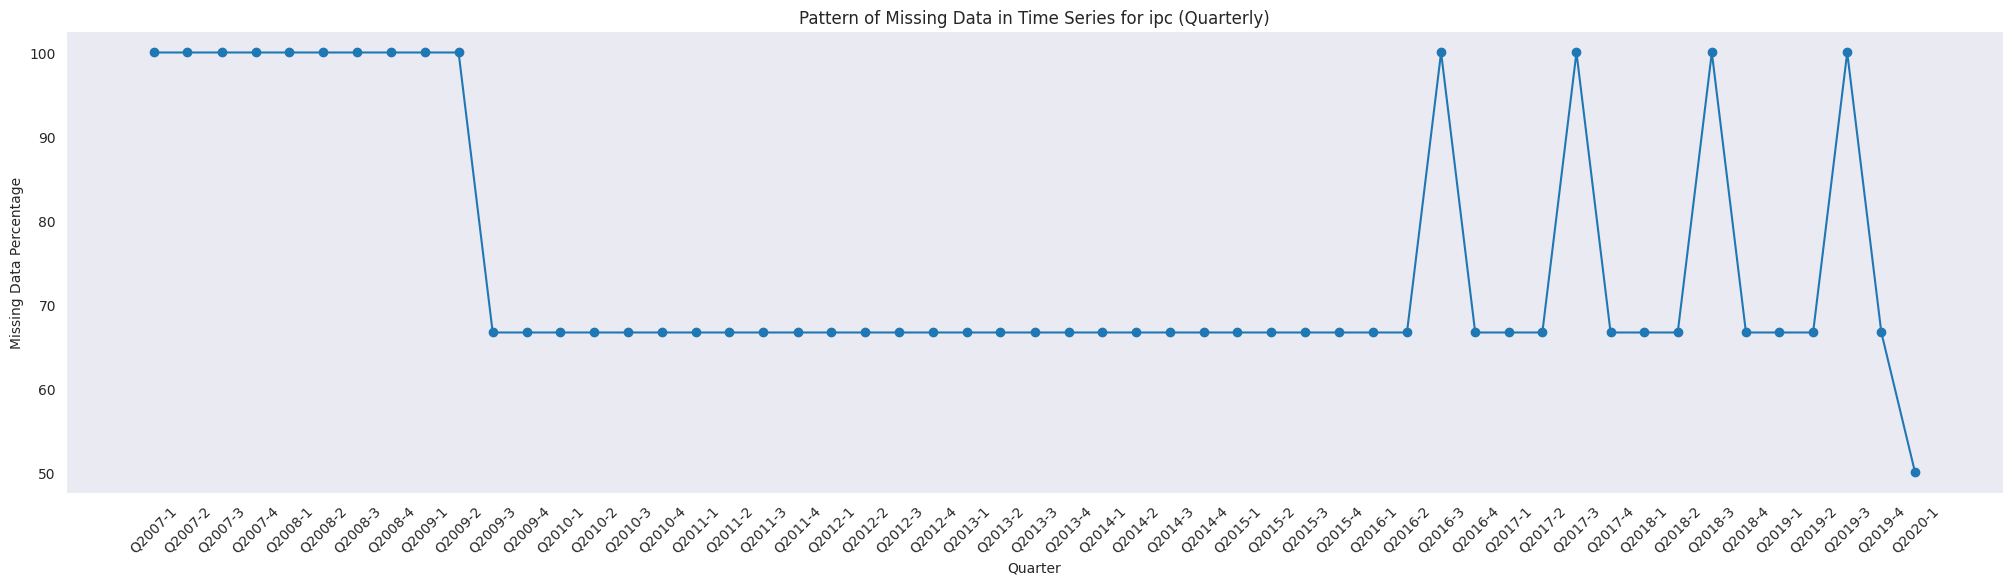

In [3]:

# Calculate the missing data percentage for each quarter
missing_data_percentage = df['ipc'].isnull().astype(int).resample('Q').mean() * 100
quarters = [f'Q{quarter.year}-{quarter.quarter}' for quarter in missing_data_percentage.index]

# Plot the missing data percentage over time (quarterly)
plt.figure(figsize=(25, 6))
plt.plot(missing_data_percentage.index, missing_data_percentage.values, marker='o', linestyle='-')
plt.xticks(missing_data_percentage.index, quarters, rotation=45)  # Set custom x-labels and rotate for readability
plt.xlabel('Quarter')
plt.ylabel('Missing Data Percentage')
plt.title('Pattern of Missing Data in Time Series for ipc (Quarterly)')
plt.grid()
plt.show()


In [4]:
# Create a new column 'quarter' based on 'datetime'
df.reset_index(inplace=True)
df['quarters'] = df['datetime'].dt.to_period('Q')
# df('quarter')['column1'].sum().reset_index()

df = df[df['quarters'] >= pd.Period('2009Q3')]

df

,datetime,country,district_code,district,centx,centy,year_month,year,month,ipc,...,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date,province,administrative_region,quarters
30,2009-07-01,South Sudan,74,Bor,32.00486,6.465644,2009_07,2009,7,2.0,...,1.098674,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-07-01,Greater Upper Nile,Greater Upper Nile,2009Q3
31,2009-08-01,South Sudan,74,Bor,32.00486,6.465644,2009_08,2009,8,NaN,...,1.171685,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-08-01,Greater Upper Nile,Greater Upper Nile,2009Q3
32,2009-09-01,South Sudan,74,Bor,32.00486,6.465644,2009_09,2009,9,NaN,...,1.194245,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-09-01,Greater Upper Nile,Greater Upper Nile,2009Q3
33,2009-10-01,South Sudan,74,Bor,32.00486,6.465644,2009_10,2009,10,2.0,...,1.185251,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-10-01,Greater Upper Nile,Greater Upper Nile,2009Q4
34,2009-11-01,South Sudan,74,Bor,32.00486,6.465644,2009_11,2009,11,NaN,...,1.197838,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-11-01,Greater Upper Nile,Greater Upper Nile,2009Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12319,2019-10-01,South Sudan,151,Malakal,31.64280,9.658457,2019_10,2019,10,3.0,...,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000,2019-10-01,Greater Upper Nile,Greater Upper Nile,2019Q4
12320,2019-11-01,South Sudan,151,Malakal,31.64280,9.658457,2019_11,2019,11,NaN,...,87.728720,757.7855,13.068690,102228.0,7145.909,85.5000,2019-11-01,Greater Upper Nile,Greater Upper Nile,2019Q4
12321,2019-12-01,South Sudan,151,Malakal,31.64280,9.658457,2019_12,2019,12,NaN,...,93.566750,757.7855,13.068690,102228.0,7145.909,85.5000,2019-12-01,Greater Upper Nile,Greater Upper Nile,2019Q4
12322,2020-01-01,South Sudan,151,Malakal,31.64280,9.658457,2020_01,2020,1,NaN,...,106.793600,757.7855,13.068690,163171.3,7145.909,85.5000,2020-01-01,Greater Upper Nile,Greater Upper Nile,2020Q1


In [7]:
df.to_csv('data/food_crises_2009.csv', index=False)

In [5]:
df.drop(['year_month_numeric', 'year', 'month'], axis=1,  inplace=True)

KeyError: "['year_month_numeric'] not found in axis"

In [57]:
df[['ipc']].describe()

,ipc
count,3042.000000
mean,2.124918
std,0.896948
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


In [6]:
def generate_aggregation_functions(df):
    aggregations = {}
    for column in df.columns:
        if column == 'ipc':
            aggregations[column] = lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan
        elif pd.api.types.is_numeric_dtype(df[column]):
            # Calculate mean for numeric columns
            aggregations[column] = 'mean'
        else:
            # Keep the first non-null value for non-numeric columns
            aggregations[column] = lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan
    return aggregations

df2 = df.copy()
# Use 'groupby' with generated aggregation functions for each column, grouping by both 'quarters' and 'regions'
aggregations = generate_aggregation_functions(df2)

df2 = df2.groupby(['quarters', 'district']).agg(aggregations)

df2

datetime      country  district_code      district  \
quarters district                                                            
2009Q3   Abiemnhom    2009-07-01  South Sudan          136.0     Abiemnhom   
         Akobo        2009-07-01  South Sudan          114.0         Akobo   
         Anzara       2009-07-01  South Sudan           86.0        Anzara   
         Aweil Center 2009-07-01  South Sudan          128.0  Aweil Center   
         Aweil East   2009-07-01  South Sudan          141.0    Aweil East   
...                          ...          ...            ...           ...   
2020Q1   Wulu         2020-01-01  South Sudan          105.0          Wulu   
         Yambio       2020-01-01  South Sudan           82.0        Yambio   
         Yei          2020-01-01  South Sudan           81.0           Yei   
         Yirol East   2020-01-01  South Sudan          107.0    Yirol East   
         Yirol West   2020-01-01  South Sudan          101.0    Yirol West   

                          centx     centy year_month    year  month  ipc  ...  \
quarters district                                                         ...   
2009Q3   Abiemnhom     29.13019  9.550939    2009_07  2009.0    8.0  2.0  ...   
         Akobo         32.85308  7.799214    2009_07  2009.0    8.0  4.0  ...   
         Anzara        28.20598  5.309739    2009_07  2009.0    8.0  1.0  ...   
         Aweil Center  26.89562  8.417934    2009_07  2009.0    8.0  2.0  ...   
         Aweil East    27.61364  9.243139    2009_07  2009.0    8.0  3.0  ...   
...                         ...       ...        ...     ...    ...  ...  ...   
2020Q1   Wulu          29.20889  6.200243    2020_01  2020.0    1.5  2.0  ...   
         Yambio        28.54729  5.124909    2020_01  2020.0    1.5  3.0  ...   
         Yei           30.34454  4.252148    2020_01  2020.0    1.5  3.0  ...   
         Yirol East    30.80245  6.793194    2020_01  2020.0    1.5  4.0  ...   
         Yirol West    30.48698  6.395244    2020_01  2020.0    1.5  3.0  ...   

                       food_price_idx       area  cropland_pct        pop  \
quarters district                                                           
2009Q3   Abiemnhom           0.931448   2408.233      1.742261   20702.00   
         Akobo               1.030483   9027.626     10.046920  158222.00   
         Anzara              0.953642   6541.319     18.819290   76442.00   
         Aweil Center        0.905515  11202.960      0.173833   48376.00   
         Aweil East          0.932802   6400.981     26.804220  345977.00   
...                               ...        ...           ...        ...   
2020Q1   Wulu               81.837355  11894.780      0.032678   45158.50   
         Yambio             76.276965   8896.165     19.126490  197278.90   
         Yei                90.810845   6713.251     16.303490  288875.40   
         Yirol East        100.745030   5599.893      2.482445   73693.13   
         Yirol West         99.746590   4879.717      0.462767  111980.60   

                       ruggedness_mean  pasture_pct        date  \
quarters district                                                 
2009Q3   Abiemnhom           11004.640     91.48276  2009-07-01   
         Akobo                2787.772     89.71963  2009-07-01   
         Anzara              51381.880     58.21333  2009-07-01   
         Aweil Center         3754.860     81.76336  2009-07-01   
         Aweil East           3544.279     90.16216  2009-07-01   
...                                ...          ...         ...   
2020Q1   Wulu                40366.550     65.10490  2020-01-01   
         Yambio              60628.160     60.88350  2020-01-01   
         Yei                 75813.310     62.85185  2020-01-01   
         Yirol East          18421.020     91.75000  2020-01-01   
         Yirol West          25073.430     87.71930  2020-01-01   

                                 province  administrative_region  quarters  
quar

Expectation-Maximization (EM) Algorithm

In [50]:

# Define the number of iterations for the EM algorithm
max_iterations = 100
tolerance = 1e-6  # Set a tolerance level for convergence

# Initialize the missing values with the mean of the observed values
observed_data = df2['ipc'].dropna()
mean_estimate = observed_data.mean()
df2['ipc'].fillna(mean_estimate, inplace=True)

# Perform the EM algorithm
for iteration in range(max_iterations):
    # E-step: Estimate the missing values based on the current parameter estimates
    missing_indices = df2['ipc'].isna()
    observed_values = df2.loc[~missing_indices, 'ipc']
    params = norm.fit(observed_values)
    df2.loc[missing_indices, 'ipc'] = params[0]  # Update missing values with the mean

    # M-step: Re-estimate the parameters of the distribution
    observed_values = df2['ipc'].dropna()
    new_params = norm.fit(observed_values)

    # Check for convergence
    if np.abs(params[0] - new_params[0]) < tolerance:
        break

print("EM Algorithm Converged after", iteration + 1, "iterations.")

df2

EM Algorithm Converged after 1 iterations.


datetime      country  district_code      district  \
quarters district                                                            
2009Q3   Abiemnhom    2009-07-01  South Sudan          136.0     Abiemnhom   
         Akobo        2009-07-01  South Sudan          114.0         Akobo   
         Anzara       2009-07-01  South Sudan           86.0        Anzara   
         Aweil Center 2009-07-01  South Sudan          128.0  Aweil Center   
         Aweil East   2009-07-01  South Sudan          141.0    Aweil East   
...                          ...          ...            ...           ...   
2020Q1   Wulu         2020-01-01  South Sudan          105.0          Wulu   
         Yambio       2020-01-01  South Sudan           82.0        Yambio   
         Yei          2020-01-01  South Sudan           81.0           Yei   
         Yirol East   2020-01-01  South Sudan          107.0    Yirol East   
         Yirol West   2020-01-01  South Sudan          101.0    Yirol West   

                          centx     centy year_month    year  month  ipc  ...  \
quarters district                                                         ...   
2009Q3   Abiemnhom     29.13019  9.550939    2009_07  2009.0    8.0  2.0  ...   
         Akobo         32.85308  7.799214    2009_07  2009.0    8.0  4.0  ...   
         Anzara        28.20598  5.309739    2009_07  2009.0    8.0  1.0  ...   
         Aweil Center  26.89562  8.417934    2009_07  2009.0    8.0  2.0  ...   
         Aweil East    27.61364  9.243139    2009_07  2009.0    8.0  3.0  ...   
...                         ...       ...        ...     ...    ...  ...  ...   
2020Q1   Wulu          29.20889  6.200243    2020_01  2020.0    1.5  2.0  ...   
         Yambio        28.54729  5.124909    2020_01  2020.0    1.5  3.0  ...   
         Yei           30.34454  4.252148    2020_01  2020.0    1.5  3.0  ...   
         Yirol East    30.80245  6.793194    2020_01  2020.0    1.5  4.0  ...   
         Yirol West    30.48698  6.395244    2020_01  2020.0    1.5  3.0  ...   

                       food_price_idx       area  cropland_pct        pop  \
quarters district                                                           
2009Q3   Abiemnhom           0.931448   2408.233      1.742261   20702.00   
         Akobo               1.030483   9027.626     10.046920  158222.00   
         Anzara              0.953642   6541.319     18.819290   76442.00   
         Aweil Center        0.905515  11202.960      0.173833   48376.00   
         Aweil East          0.932802   6400.981     26.804220  345977.00   
...                               ...        ...           ...        ...   
2020Q1   Wulu               81.837355  11894.780      0.032678   45158.50   
         Yambio             76.276965   8896.165     19.126490  197278.90   
         Yei                90.810845   6713.251     16.303490  288875.40   
         Yirol East        100.745030   5599.893      2.482445   73693.13   
         Yirol West         99.746590   4879.717      0.462767  111980.60   

                       ruggedness_mean  pasture_pct        date  \
quarters district                                                 
2009Q3   Abiemnhom           11004.640     91.48276  2009-07-01   
         Akobo                2787.772     89.71963  2009-07-01   
         Anzara              51381.880     58.21333  2009-07-01   
         Aweil Center         3754.860     81.76336  2009-07-01   
         Aweil East           3544.279     90.16216  2009-07-01   
...                                ...          ...         ...   
2020Q1   Wulu                40366.550     65.10490  2020-01-01   
         Yambio              60628.160     60.88350  2020-01-01   
         Yei                 75813.310     62.85185  2020-01-01   
         Yirol East          18421.020     91.75000  2020-01-01   
         Yirol West          25073.430     87.71930  2020-01-01   

                                 province  administrative_region  quarters  
quar

In [8]:

trial = df2
# Create a copy of the 'ipc' column for later comparison
observed_values = trial['ipc'].copy()

# Randomly set some observed values to NaN
np.random.seed(42)  # for reproducibility
missing_indices = np.random.choice(len(observed_values), size=int(0.2 * len(observed_values)), replace=False)
observed_values[missing_indices] = np.nan

# Define the number of iterations for the EM algorithm
max_iterations = 100
tolerance = 1e-6  # Set a tolerance level for convergence

# Perform the EM algorithm
for iteration in range(max_iterations):
    # E-step: Estimate the missing values based on the current parameter estimates
    missing_indices = np.isnan(observed_values)
    observed_data = observed_values[~missing_indices]
    params = norm.fit(observed_data)
    observed_values[missing_indices] = params[0]  # Update missing values with the mean

    # M-step: Re-estimate the parameters of the distribution
    observed_data = observed_values[~missing_indices]
    new_params = norm.fit(observed_data)

    # Check for convergence
    if np.abs(params[0] - new_params[0]) < tolerance:
        break

print("EM Algorithm Converged after", iteration + 1, "iterations.")

# Calculate mean absolute error (MAE) using the imputed values and the original observed values
mae = np.abs(observed_values[~missing_indices] - trial['ipc'][~missing_indices]).mean()

# Calculate root mean square error (RMSE)
rmse = np.sqrt(((observed_values[~missing_indices] - trial['ipc'][~missing_indices])**2).mean())

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Square Error (RMSE):", rmse)


EM Algorithm Converged after 1 iterations.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [10]:
# Calculate summary statistics for the column with missing data
sum_stats = df2[['ipc']].describe()

sum_stats

,ipc
count,3354.000000
mean,2.124918
std,0.854198
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


In [12]:
df2.to_csv('data/food_crises_quarter_imputed.csv')

In [55]:

def assign_ipc(row):
    q = row['quarters']
    d = row['district']
    condition = ((df2['quarters'] == q) & (df2['district'] == d))
    ipc = df2.loc[condition, 'ipc'].values[0] if condition.any() else None
    return ipc

df['ipc'] = df.apply(assign_ipc, axis=1)

df

,datetime,country,district_code,district,centx,centy,year_month,year,month,ipc,...,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date,province,administrative_region,quarters
30,2009-07-01,South Sudan,74,Bor,32.00486,6.465644,2009_07,2009,7,2.0,...,1.098674,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-07-01,Greater Upper Nile,Greater Upper Nile,2009Q3
31,2009-08-01,South Sudan,74,Bor,32.00486,6.465644,2009_08,2009,8,2.0,...,1.171685,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-08-01,Greater Upper Nile,Greater Upper Nile,2009Q3
32,2009-09-01,South Sudan,74,Bor,32.00486,6.465644,2009_09,2009,9,2.0,...,1.194245,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-09-01,Greater Upper Nile,Greater Upper Nile,2009Q3
33,2009-10-01,South Sudan,74,Bor,32.00486,6.465644,2009_10,2009,10,2.0,...,1.185251,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-10-01,Greater Upper Nile,Greater Upper Nile,2009Q4
34,2009-11-01,South Sudan,74,Bor,32.00486,6.465644,2009_11,2009,11,2.0,...,1.197838,14008.3300,7.961984,256618.0,11393.760,90.8503,2009-11-01,Greater Upper Nile,Greater Upper Nile,2009Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12319,2019-10-01,South Sudan,151,Malakal,31.64280,9.658457,2019_10,2019,10,3.0,...,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000,2019-10-01,Greater Upper Nile,Greater Upper Nile,2019Q4
12320,2019-11-01,South Sudan,151,Malakal,31.64280,9.658457,2019_11,2019,11,3.0,...,87.728720,757.7855,13.068690,102228.0,7145.909,85.5000,2019-11-01,Greater Upper Nile,Greater Upper Nile,2019Q4
12321,2019-12-01,South Sudan,151,Malakal,31.64280,9.658457,2019_12,2019,12,3.0,...,93.566750,757.7855,13.068690,102228.0,7145.909,85.5000,2019-12-01,Greater Upper Nile,Greater Upper Nile,2019Q4
12322,2020-01-01,South Sudan,151,Malakal,31.64280,9.658457,2020_01,2020,1,4.0,...,106.793600,757.7855,13.068690,163171.3,7145.909,85.5000,2020-01-01,Greater Upper Nile,Greater Upper Nile,2020Q1


In [57]:
df.to_csv('data/food_crises_month_imputed.csv', index=False)